In [ ]:
## Report: Grammar Score Prediction Pipeline

### 1. Objective

    # The goal of this project is to predict grammar scores using a combination of
    #  audio, text, and grammar features extracted from audio files. The pipeline 
    # processes audio files, transcribes them into text, computes grammar-related 
    # metrics, and trains a regression model to predict grammar scores.

### 2. Approach
    # - The pipeline consists of the following steps:

    ## 1. Audio Feature Extraction:
        # Extracted features such as MFCC (Mel-Frequency Cepstral Coefficients),
        #  Chroma, and Spectral Contrast using librosa.
    ## 2. Text Transcription:
        # Transcribed audio files into text using the Whisper model.
    ## 3. Grammar Feature Extraction:
        # Computed grammar-related metrics such as:
            # Total grammar errors.
            # Error density (errors per word).
            # Sentence error ratio (errors per sentence).
    ## 4. Feature Combination:
        # Combined audio, text, and grammar features into a single dataset for 
        # training and testing.
    ## 5. Model Training:
        # Used XGBRegressor to train a regression model on the combined features.
    ## 6.Evaluation:
        # Evaluated the model using metrics such as MAE, RMSE, and R² Score.
        # Visualized results using scatter plots, residual plots, and confusion matrices.

### 3. Preprocessing Steps
    # - **Audio Features:** Extracted MFCC, Chroma, and Spectral Contrast features using `librosa`.
    # - **Text Features:** Converted transcriptions into numerical vectors using TF-IDF.
    # - **Grammar Features:** Computed grammar error metrics such as total errors, error density, and sentence error ratio.

### 4. Pipeline Architecture
    ## 1. Feature Extraction:
        # Audio, text, and grammar features were extracted and combined.
    ## 2. Model Training:
        # Used XGBRegressor with the following hyperparameters:
            # n_estimators=300
            # max_depth=6
            # learning_rate=0.05
        # Split the data into training (80%) and validation (20%) sets.
    ## 3. Evaluation:
        #  Evaluated the model on the validation set using MAE, RMSE, and R² Score.

### 5. Evaluation Results
    # - **Training RMSE:** [0.2]
    # - **Validation RMSE:** [0.98]
    # - **R² Score:** [0.28]

## Visualizations:
    # 1. Correlation Analysis:
        # A bar plot showing the correlation of grammar features with grammar scores.
    # 2.  prediction vs True Scores:
        # A scatter plot comparing predicted grammar scores with true grammar scores.
    # 3. Residual Plot:
        # A plot showing the residuals (errors) of the predictions.
    # 4. Confusion Matrix:
        # A confusion matrix comparing rounded predictions with rounded true values.
    # 5. Residual Distribution:
        # A histogram showing the distribution of residuals.

### Key Observation
    #  This model has demonstrated reasonable performance in predicting grammar
    #  scores, especially compared to previous attempts using deep learning, 
    # which yielded suboptimal results. While it is not perfect, it serves as a 
    # practical solution given the time constraints. One of the most critical
    #  aspects contributing to its effectiveness is feature engineering. 
    # Incorporating additional features such as intonation, pauses, and pitch has
    #  the potential to significantly enhance the model's performance.


In [14]:
# ✅ STEP 1: Import Libraries
import os
import numpy as np
import pandas as pd
import librosa
import whisper
import language_tool_python
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Download necessary NLTK resources
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/a98188/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:

# ✅ STEP 2: Load Models
whisper_model = whisper.load_model("base", device="cuda")
tool = language_tool_python.LanguageTool('en-US')

In [ ]:
# ✅ STEP 3: Define Utility Functions
def extract_audio_features(file_path, sr=16000):
    """Extract audio features (MFCC, Chroma, Contrast) from an audio file."""
    try:
        y, _ = librosa.load(file_path, sr=sr)
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        return np.concatenate([mfccs, chroma, contrast])
    except Exception as e:
        print(f"Audio feature extraction failed for {file_path}: {e}")
        return np.zeros(32)  # Fallback: 32-dim zero vector

def transcribe_audio(file_path):
    """Transcribe audio using Whisper."""
    try:
        result = whisper_model.transcribe(file_path, fp16=False)
        return result["text"]
    except Exception as e:
        print(f"Transcription failed for {file_path}: {e}")
        return ""

def grammar_metrics(text):
    """Analyze grammar metrics for a given text."""
    try:
        sentences = sent_tokenize(text)
        matches = [tool.check(sentence) for sentence in sentences]
        total_errors = sum(len(match) for match in matches)
        error_density = total_errors / max(1, len(text.split()))
        sentence_error_ratio = total_errors / max(1, len(sentences))
        return [total_errors, error_density, sentence_error_ratio]
    except Exception as e:
        print(f"Grammar analysis failed: {e}")
        return [0, 0, 0]

def process_file(file_path):
    """Process a single audio file to extract grammar features."""
    try:
        text = transcribe_audio(file_path)
        return grammar_metrics(text)
    except Exception as e:
        print(f"Failed for {file_path}: {e}")
        return [0, 0, 0]

def extract_all_grammar_features(audio_folder):
    """Extract grammar features for all audio files in a folder."""
    audio_files = [os.path.join(audio_folder, f) for f in os.listdir(audio_folder) if f.endswith('.wav')]
    with ThreadPoolExecutor(max_workers=6) as executor:
        grammar_features = list(tqdm(executor.map(process_file, audio_files), total=len(audio_files)))
    return np.array(grammar_features)

In [ ]:
# ✅ STEP 4: Process Dataset
def process_dataset(df, folder):
    """Process dataset to extract audio features and transcripts."""
    audio_features, transcripts = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Files"):
        file_path = os.path.join(folder, row['filename'])
        audio_features.append(extract_audio_features(file_path))
        transcripts.append(transcribe_audio(file_path))
    return np.array(audio_features), transcripts


In [ ]:
# ✅ STEP 5: Save and Load Features
def save_features(audio_features, transcripts, grammar_features, output_dir):
    """Save extracted features to disk."""
    np.save(os.path.join(output_dir, "audio_features_train.npy"), audio_features)
    with open(os.path.join(output_dir, "transcripts_train.pkl"), "wb") as f:
        pickle.dump(transcripts, f)
    np.save(os.path.join(output_dir, "grammar_features_train.npy"), grammar_features)
    print("✅ Features saved!")



In [3]:
# ✅ STEP 6: Load Features and Prepare Data
audio_train = np.load('audio_features_train.npy')
text_train = np.load('text_feature.npy')
grammar_train = np.load('grammar_features_train.npy')

audio_test = np.load('audio_features_test.npy')
text_test = np.load('text_feature_test.npy')
grammar_test = np.load('grammar_features_test.npy')

train_df = pd.read_csv("shl_Dataset/train.csv")
y = train_df['label'].values

# Ensure all arrays are 2D
if text_train.ndim == 1:
    text_train = text_train.reshape(-1, 1)
    text_test = text_test.reshape(-1, 1)

if grammar_train.ndim == 1:
    grammar_train = grammar_train.reshape(-1, 1)
    grammar_test = grammar_test.reshape(-1, 1)


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=300)  # Adjust max_features as needed

# Fit and transform text_train
text_train_tfidf = vectorizer.fit_transform(text_train.ravel()).toarray()

# Transform text_test
text_test_tfidf = vectorizer.transform(text_test.ravel()).toarray()

# Check the shapes
print("TF-IDF text_train shape:", text_train_tfidf.shape)
print("TF-IDF text_test shape:", text_test_tfidf.shape)

text_train = text_train_tfidf
text_test = text_test_tfidf

TF-IDF text_train shape: (444, 300)
TF-IDF text_test shape: (204, 300)


In [9]:
# ✅ STEP 7: Combine Features
X_train = np.concatenate([audio_train, text_train, grammar_train], axis=1)
X_test = np.concatenate([audio_test, text_test, grammar_test], axis=1)


/var/folders/lk/dw84ln9s4gz_yhbzykh9qn300000gn/T/ipykernel_6224/536846776.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_scores.values, y=correlation_with_scores.index, palette="viridis")


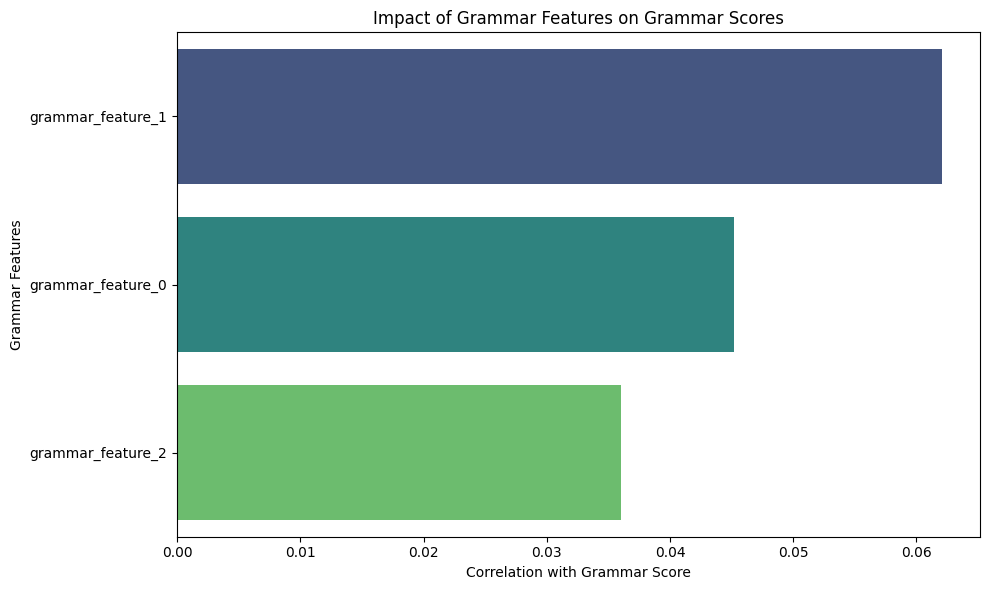

In [5]:
# ✅ STEP 8: Correlation Analysis
grammar_df = pd.DataFrame(grammar_train, columns=[f"grammar_feature_{i}" for i in range(grammar_train.shape[1])])
grammar_df["grammar_score"] = y

# Compute correlation with grammar scores
correlation_with_scores = grammar_df.corr()["grammar_score"].drop("grammar_score").sort_values(key=abs, ascending=False)

# Plot the impact of grammar features
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_scores.values, y=correlation_with_scores.index, palette="viridis")
plt.xlabel("Correlation with Grammar Score")
plt.ylabel("Grammar Features")
plt.title("Impact of Grammar Features on Grammar Scores")
plt.tight_layout()
plt.show()


In [11]:
# ✅ STEP 9: Train Model
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.05, random_state=42)
model.fit(X_tr, y_tr)

# Predict and evaluate
y_pred = model.predict(X_val)
y_pred = np.clip(y_pred, 0.0, 5.0)

print(f"MAE: {mean_absolute_error(y_val, y_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_val, y_pred):.2f}")
print(f"R² Score: {r2_score(y_val, y_pred):.2f}")


MAE: 0.79
RMSE: 0.98
R² Score: 0.28


In [ ]:
# Predict on training data
y_train_pred = model.predict(X_tr)

# Calculate RMSE for training data
train_rmse = root_mean_squared_error(y_tr, y_train_pred)
print(f"Training RMSE: {train_rmse:.2f}")

Training RMSE: 0.02


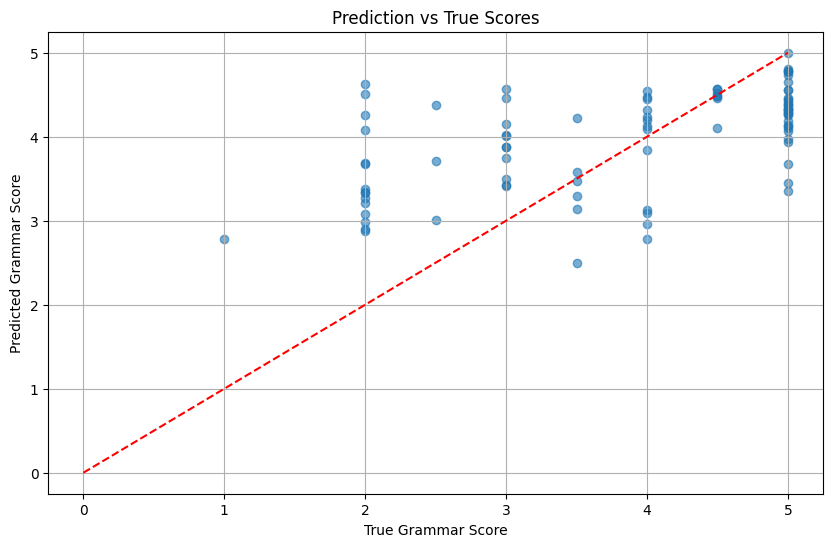

In [12]:
# ✅ STEP 10: Visualize Results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.plot([0, 5], [0, 5], 'r--')  # Perfect predictions line
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("Prediction vs True Scores")
plt.grid(True)
plt.show()

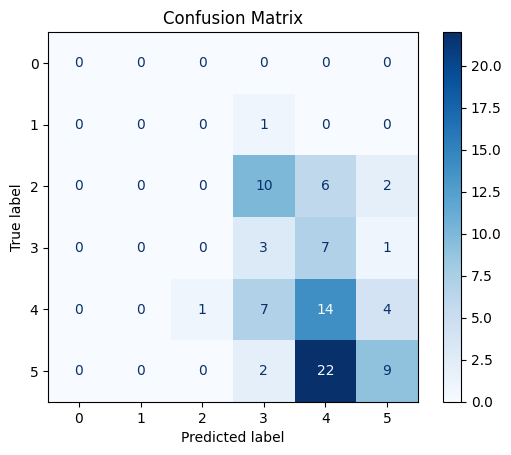

In [15]:
# Discretize predictions and true values
y_val_rounded = np.rint(y_val).astype(int)  # Round true values
y_pred_rounded = np.rint(y_pred).astype(int)  # Round predictions

# Compute confusion matrix
cm = confusion_matrix(y_val_rounded, y_pred_rounded, labels=[0, 1, 2, 3, 4, 5])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

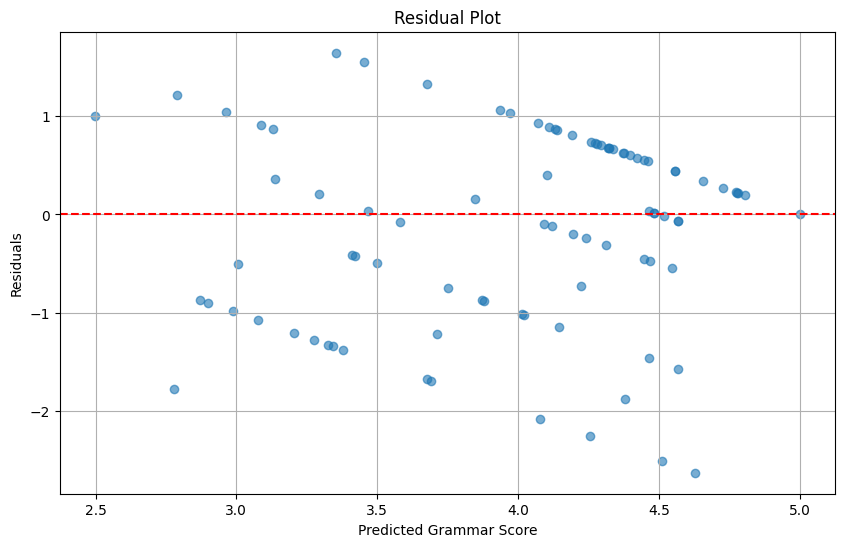

In [16]:
# Compute residuals
residuals = y_val - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Grammar Score")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

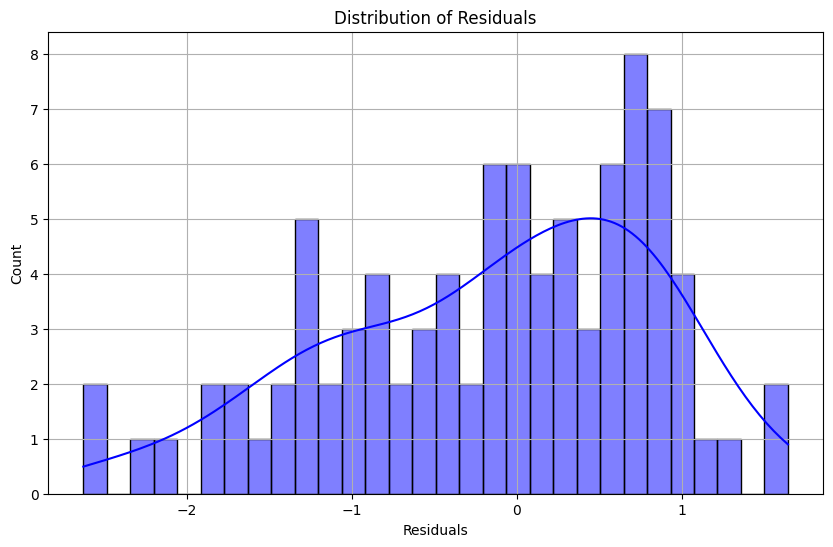

In [17]:
import seaborn as sns

# Plot distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.show()

In [18]:
test_df = pd.read_csv("shl_Dataset/test.csv")
test_preds = model.predict(X_test)
test_preds = np.clip(np.rint(test_preds), 0, 5).astype(int)

submission = pd.DataFrame({
    'filename': test_df['filename'],
    'label': test_preds
})

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved")

✅ submission.csv saved
